In [2]:
import itertools
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

%matplotlib inline

/Users/paulo.vasconcellos/.pyenv/versions/3.8.5/lib/python3.8/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


# Functions

In [104]:
def generate_recommendations(basket, products_matrix, number_of_recommendations):
    '''
    Given a similarity matrix and a product, returns recommendations to the user
    '''
    also_purchased = products_matrix[basket]
    also_purchased = also_purchased.sort_values(ascending=False)
    recommendations = list(also_purchased.index[:number_of_recommendations])
    
    return recommendations

# Reading dataset

In [3]:
df = pd.read_excel('data/raw/Online Retail.xlsx', header = 0)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
print('dataset dimensions are:', df.shape)
df.describe(include = 'all')

dataset dimensions are: (541909, 8)


<ipython-input-4-1aa4d36225a5>:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe(include = 'all')


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
count,541909.0,541909,540455,541909.000000,541909,541909.000000,406829.000000,541909
unique,25900.0,4070,4223,NaN,23260,NaN,NaN,38
top,573585.0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,2011-10-31 14:41:00,NaN,NaN,United Kingdom
freq,1114.0,2313,2369,NaN,1114,NaN,NaN,495478
first,NaN,NaN,NaN,NaN,2010-12-01 08:26:00,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,2011-12-09 12:50:00,NaN,NaN,NaN
mean,NaN,NaN,NaN,9.552250,NaN,4.611114,15287.690570,NaN
std,NaN,NaN,NaN,218.081158,NaN,96.759853,1713.600303,NaN
min,NaN,NaN,NaN,-80995.000000,NaN,-11062.060000,12346.000000,NaN
25%,NaN,NaN,NaN,1.000000,NaN,1.250000,13953.000000,NaN


In [5]:
# Uncomment the line below to use just a sample of the dataset
df_sample = df.copy()

# df_sample = df.copy().iloc[:1000] 
df_sample

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


# Data preprocessing 

In [6]:
# Delete rows with no Customer ID (if there is such a case)
cleaned_retail = df_sample.loc[pd.isnull(df_sample.CustomerID) == False]

# Create a lookup table
item_lookup = cleaned_retail[['StockCode', 'Description']].drop_duplicates()
item_lookup.loc['StockCode'] = item_lookup['StockCode'].astype(str)

cleaned_retail.loc['CustomerID'] = cleaned_retail['CustomerID'].astype(int)
cleaned_retail = cleaned_retail[['StockCode', 'Quantity', 'CustomerID']]
grouped_cleaned = cleaned_retail.groupby(['CustomerID', 'StockCode']).sum().reset_index()
grouped_cleaned.loc[grouped_cleaned['Quantity'] == 0, 'Quantity'] = 1
grouped_purchased = grouped_cleaned.query('Quantity > 0')

/Users/paulo.vasconcellos/.pyenv/versions/3.8.5/lib/python3.8/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


In [7]:
# Count number of products and number of customers in the reduced dataset 
no_products = len(grouped_purchased.StockCode.unique())
no_customers = len(grouped_purchased.CustomerID.unique())
print('Number of customers in dataset:', no_customers)
print('Number of products in dataset:', no_products)

Number of customers in dataset: 4338
Number of products in dataset: 3664


# Creating adjacency matrix

In [8]:
# Pivoting table
ratings = grouped_purchased.pivot(index = 'CustomerID', columns='StockCode', values='Quantity').fillna(0).astype('int')

# Binarize the ratings matrix (indicate only if a customer has purchased a product or not)
ratings_binary = ratings.copy()
ratings_binary[ratings_binary != 0] = 1

In [9]:
%%time
# Initialize zeros dataframe for product interactions
products_integer = np.zeros((no_products,no_products))

# Count how many times each product pair has been purchased
print('Counting how many times each pair of products has been purchased...')
for i, j in itertools.combinations(range(no_products), 2):
    if i != j:
        df_ij = ratings_binary.iloc[:,[i,j]] # create a temporary df with only i and j products as columns
        sum_ij = df_ij.sum(axis=1)
        pairings_ij = len(sum_ij[sum_ij == 2]) # if s1_ij == 2 it means that both products were purchased by the same customer
        products_integer[i, j] = pairings_ij
        products_integer[j, i] = pairings_ij

np.save('data/processed/weighted_matrix.npy', products_integer) # Saving weights
products_integer

Counting how many times each pair of products has been purchased...
CPU times: user 1h 6min 9s, sys: 17.8 s, total: 1h 6min 27s
Wall time: 1h 6min 28s


array([[ 0.,  0.,  3., ...,  6.,  0.,  9.],
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 3.,  0.,  0., ...,  5.,  0.,  1.],
       ...,
       [ 6.,  1.,  5., ...,  0.,  0., 19.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 9.,  0.,  1., ..., 19.,  0.,  0.]])

In [10]:
# Count how many customers have purchased each item
print('Counting how many times each individual product has been purchased...')
times_purchased = products_integer.sum(axis = 1)
times_purchased

Counting how many times each individual product has been purchased...


array([10129.,  2887.,  5688., ..., 32367.,   390., 23671.])

# Building similarity matrix

In [11]:
%%time

# Construct final weighted matrix of item interactions
print('Building weighted product matrix...')
products_weighted = np.zeros((no_products,no_products))

for i, j in itertools.combinations(range(no_products), 2):
    if (times_purchased[i]+times_purchased[j]) !=0: # Making sure we are not dividing by zero
        products_weighted[i,j] = (products_integer[i,j])/(times_purchased[i]+times_purchased[j])
            
np.save('data/processed/weighted_matrix.npy', products_weighted)

Building weighted product matrix...
CPU times: user 10.4 s, sys: 92.7 ms, total: 10.5 s
Wall time: 10.7 s


# Visualizing the network

In [12]:
# Get list of item labels (instead of Codes)
nodes_codes = np.array(ratings_binary.columns)#.astype('str')
item_lookup_dict = pd.Series(item_lookup['Description'].values,index=item_lookup['StockCode']).to_dict()
nodes_labels = [item_lookup_dict[code] for code in nodes_codes]

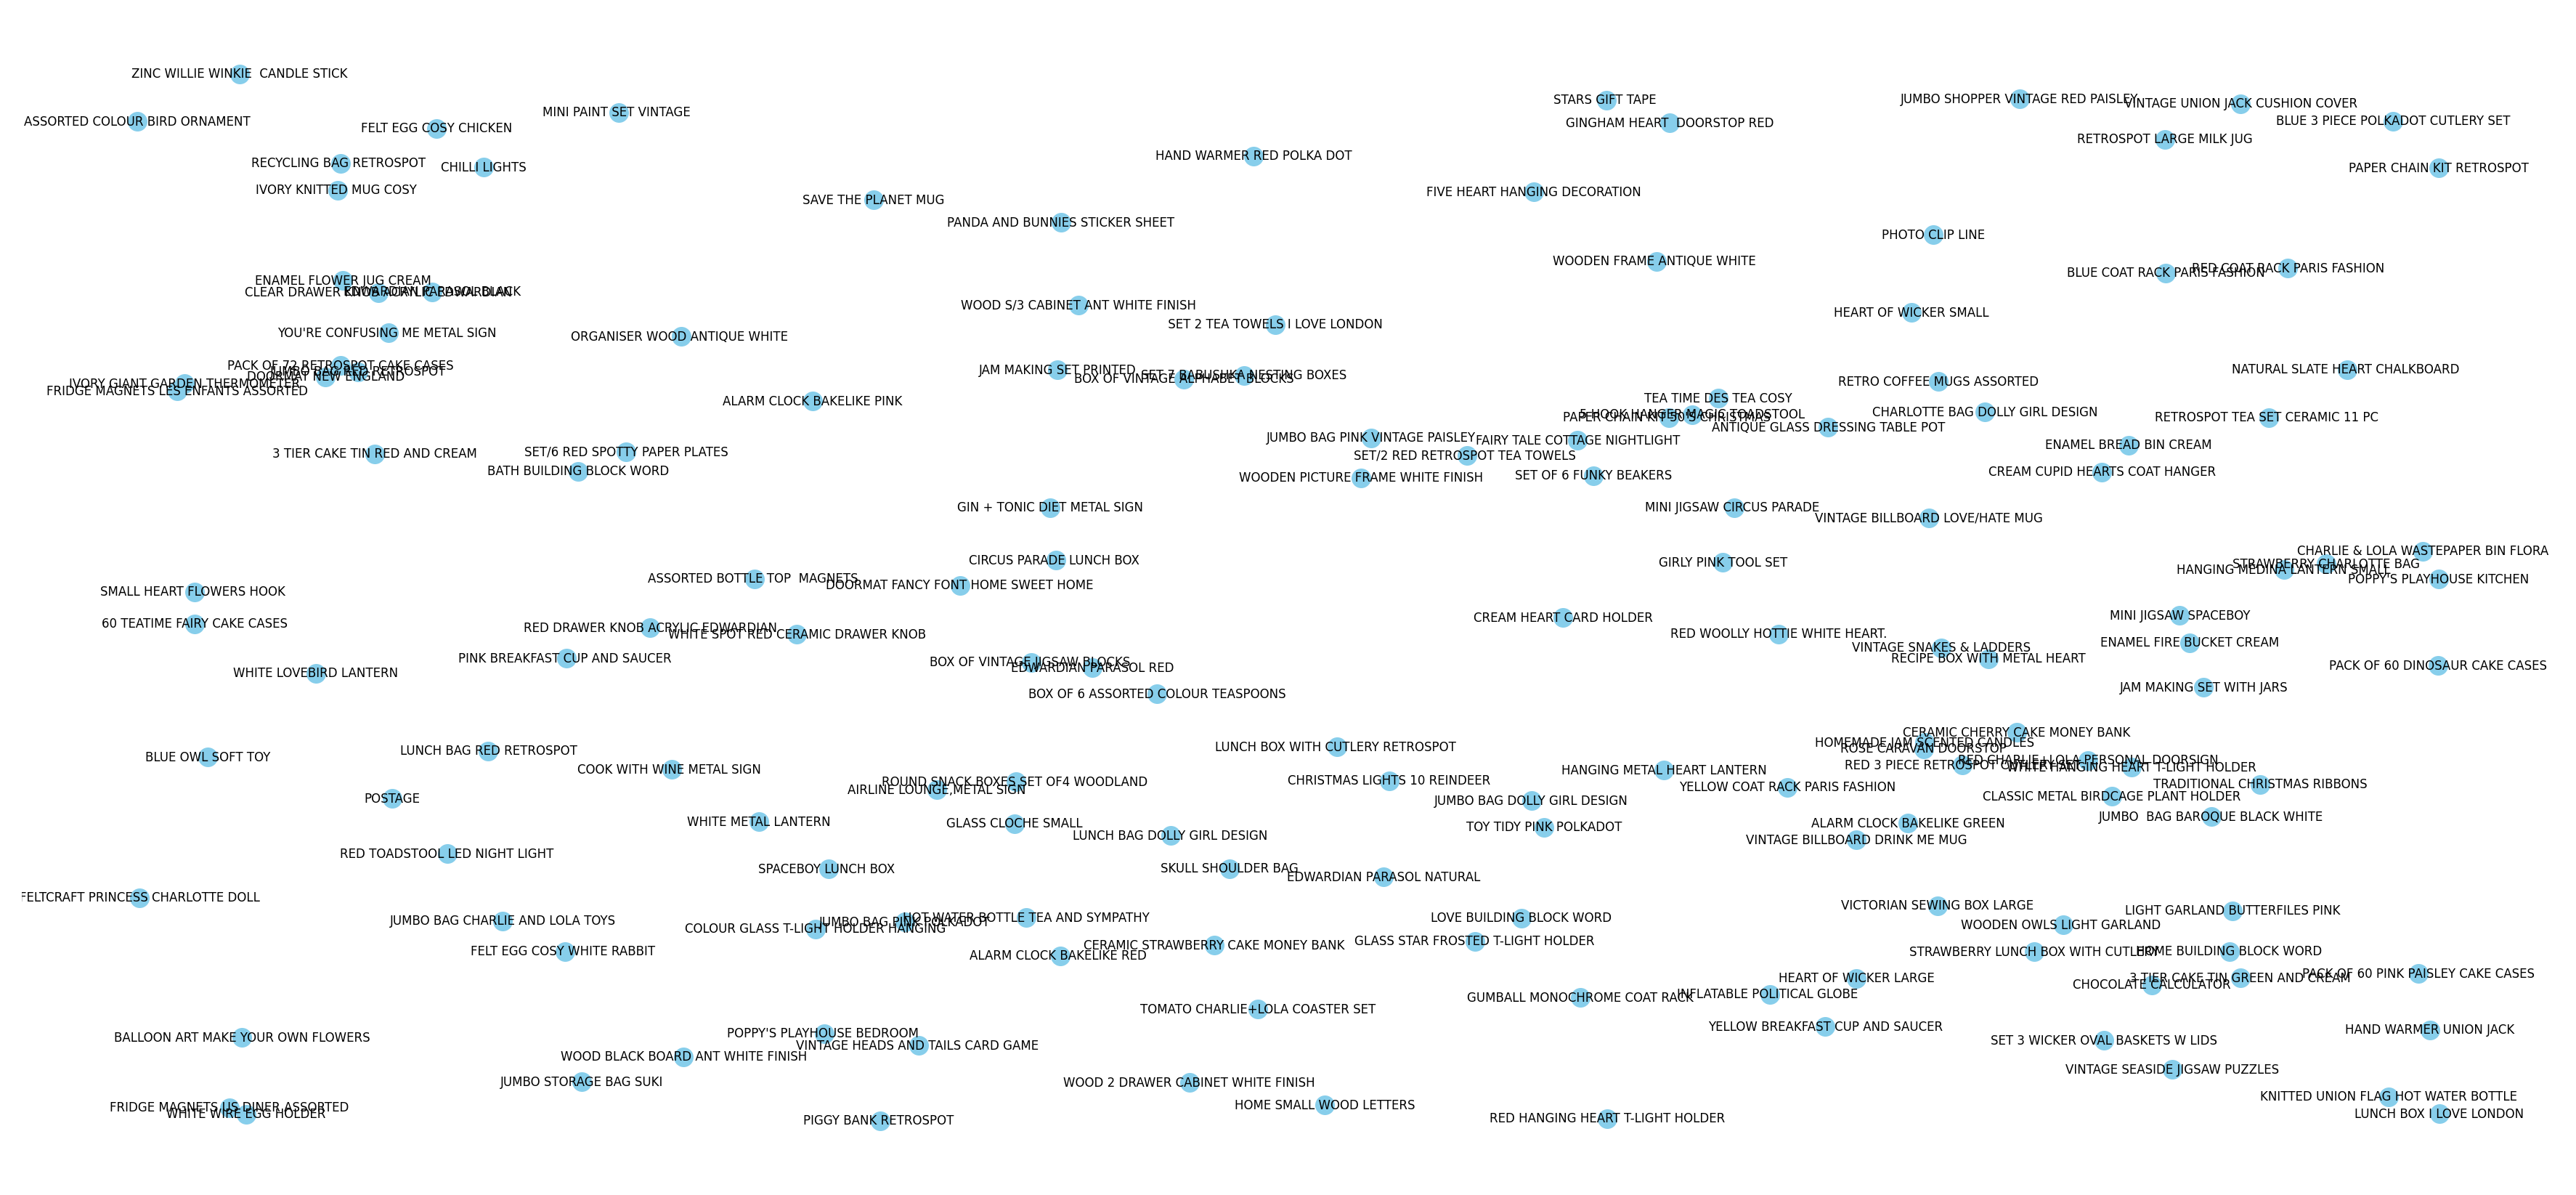

In [69]:
# Create Graph object using the weighted product matrix as adjacency matrix
G = nx.from_numpy_matrix(products_weighted)
pos = nx.random_layout(G)
labels = {}

for idx, node in enumerate(G.nodes()):
    labels[node] = nodes_labels[idx]

plt.figure(figsize=(15,7), dpi=300)
nx.draw_networkx_nodes(G, pos , node_color="skyblue", node_size=30)
nx.draw_networkx_edges(G, pos,  edge_color='k', width= 0.3, alpha= 0.5)
nx.draw_networkx_labels(G, pos, labels, font_size=4)
plt.axis('off')
plt.show() # Display

In [17]:
# Export graph to Gephi
H = nx.relabel_nodes(G, labels) # Create a new graph with Description labels and save to Gephi for visualizations
nx.write_gexf(H, 'network/products.gexf')

In [23]:
# Now we divide each element in products_weighted by the maximum of each row, in order to normalize the values.
# We can read this as the possibility of a customer buy a product j given a product i

products_weighted_pd = pd.DataFrame(products_weighted, columns = nodes_labels)
products_weighted_pd.set_index(products_weighted_pd.columns, 'product', inplace=True)

products_prob = products_weighted_pd.divide(products_weighted_pd.max(axis = 1), axis = 0)

# Generating recommendations
Creating recommendations given a product. Imagining that a person show an interest in product `i`, what other products she might also consider to buy?

In [105]:
basket = 'MURANO STYLE GLASS BRACELET BLACK'
recommendations = generate_recommendations(basket, products_prob, number_of_recommendations=3)

print('Who bought: {}\nMay also consider buying: {}'.format(basket, recommendations))

Who bought: MURANO STYLE GLASS BRACELET BLACK
May also consider buying: ['GLASS BEAD HOOP EARRINGS AMETHYST', 'MURANO STYLE GLASS BRACELET RED', 'ECONOMY HOLIDAY PURSE']


In [101]:
basket = 'DOLLY GIRL LUNCH BOX'
recommendations = generate_recommendations(basket, products_prob, number_of_recommendations=3)

print('Who bought: {}\nMay also consider buying: {}'.format(basket, recommendations))

Who bought: DOLLY GIRL LUNCH BOX
May also consider buying: ['SPACEBOY LUNCH BOX ', 'POPCORN HOLDER', 'SPACEBOY TV DINNER TRAY']


In [102]:
basket = 'FOLDING UMBRELLA CREAM POLKADOT'
recommendations = generate_recommendations(basket, products_prob, number_of_recommendations=3)

print('Who bought: {}\nMay also consider buying: {}'.format(basket, recommendations))

Who bought: FOLDING UMBRELLA CREAM POLKADOT
May also consider buying: ['FOLDING UMBRELLA RED/WHITE POLKADOT', 'FOLDING UMBRELLA BLACKBLUE POLKADOT', "DOLLY MIXTURE CHILDREN'S UMBRELLA"]
